# Problem Set 5
## [Ruolin Fang]

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate as intgr
import scipy.stats as sts
import scipy.optimize as opt
import numpy.linalg as lin
import warnings
warnings.filterwarnings('ignore')

## Question 1
### (a)

Text(0,0.5,'Percentage')

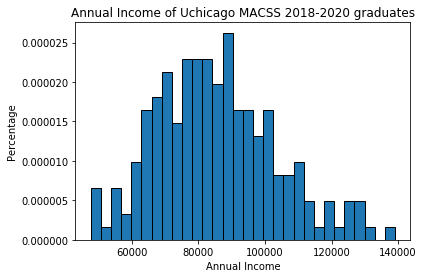

In [2]:
inc = pd.read_csv('data/incomes.txt', names = ['Income'])
plt.hist(inc['Income'], 30, normed=True, edgecolor='k')
plt.title('Annual Income of Uchicago MACSS 2018-2020 graduates')
plt.xlabel('Annual Income')
plt.ylabel('Percentage')

### (b)

In [3]:
# Define function that generates values of a lognormal pdf
def trunc_lognorm_pdf(xvals, mu, sigma, cut_lb, cut_ub):
    
    if cut_ub == 'None' and cut_lb == 'None':
        prob_notcut = 1.0
    elif cut_ub == 'None' and cut_lb != 'None':
        prob_notcut = 1.0 - sts.lognorm.cdf(cut_lb, sigma, scale=np.exp(mu))
    elif cut_ub != 'None' and cut_lb == 'None':
        prob_notcut = sts.lognorm.cdf(cut_ub, sigma, scale=np.exp(mu))
    elif cut_ub != 'None' and cut_lb != 'None':
        prob_notcut = (sts.lognorm.cdf(cut_ub, sigma, scale=np.exp(mu)) -
                       sts.lognorm.cdf(cut_lb, sigma, scale=np.exp(mu)))
            
    pdf_vals    = ((1/(xvals * sigma * np.sqrt(2 * np.pi)) *
                    np.exp( - (np.log(xvals) - mu) ** 2 / (2 * sigma ** 2))) /
                    prob_notcut)
    
    return pdf_vals

In [4]:
def data_moments(xvals):
    mean_data = xvals.mean()
    sd_data = xvals.std()   
    return mean_data, sd_data


def model_moments(mu, sigma, cut_lb, cut_ub):  
    xfx = lambda x: x * trunc_lognorm_pdf(x, mu, sigma, cut_lb, cut_ub)
    (mean_model, m_m_err) = intgr.quad(xfx, cut_lb, cut_ub)
    x2fx = lambda x: ((x - mean_model) ** 2) * trunc_lognorm_pdf(x, mu, sigma, cut_lb, cut_ub) 
    (var_model, v_m_err) = intgr.quad(x2fx, cut_lb, cut_ub)    
    sd_model = np.sqrt(var_model)
    return mean_model, sd_model


def err_vec(xvals, mu, sigma, cut_lb, cut_ub, simple):
    mean_data, sd_data = data_moments(xvals)
    moms_data = np.array([[mean_data], [sd_data]])
    mean_model, sd_model = model_moments(mu, sigma, cut_lb, cut_ub)
    moms_model = np.array([[mean_model], [sd_model]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec


def criterion(params, *args):
    mu, sigma = params
    xvals, cut_lb, cut_ub, W = args
    err = err_vec(xvals, mu, sigma, cut_lb, cut_ub, simple=False)
    crit_val = err.T @ W @ err
    
    return crit_val

In [5]:
mu_init = 11.0
sig_init = 0.5
params_init = np.array([mu_init, sig_init])
W_hat = np.eye(2)
gmm_args = (inc['Income'], 0.0, 150000.0, W_hat)
results = opt.minimize(criterion, params_init, args=(gmm_args), tol=1e-14,
                       method='L-BFGS-B', bounds=((None, None), (1e-10, None)))
mu_GMM1, sig_GMM1 = results.x
print('mu_GMM1=', mu_GMM1, ' sig_GMM1=', sig_GMM1)

mu_GMM1= 11.33353348254703  sig_GMM1= 0.2138619143524033


In [6]:
mean_data, sd_data = data_moments(inc['Income'])
mean_model, sd_model = model_moments(mu_GMM1, sig_GMM1, 0.0, 150000.0)
err1 = err_vec(inc['Income'], mu_GMM1, sig_GMM1, 0.0, 150000.0, False).reshape(2,)
print('Mean of points =', mean_data, ', Standard deviation of points =', sd_data)
print('Mean of model =', mean_model, ', Standard deviation of model =', sd_model)
print('Error vector =', err1)
print('Value of GMM criterion function =', results.fun[0, 0])

Mean of points = 85276.82360625808 , Standard deviation of points = 18037.692869371564
Mean of model = 85276.82405894193 , Standard deviation of model = 18037.69242475689
Error vector = [ 5.30840417e-09 -2.46491986e-08]
Value of GMM criterion function = 6.357621470324519e-16


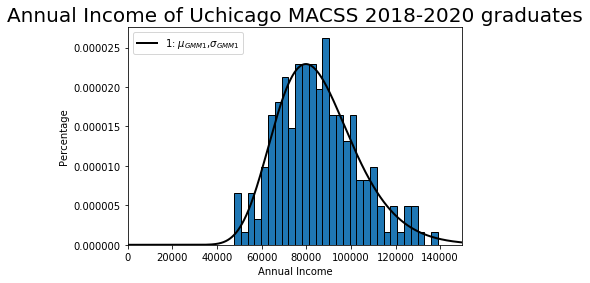

In [7]:
# Plot the histogram of the data
num_bins = 30
count, bins, ignored = plt.hist(inc['Income'], num_bins, density=True,
                                edgecolor='k')
plt.title('Annual Income of Uchicago MACSS 2018-2020 graduates', fontsize=20)
plt.xlabel(r'Annual Income')
plt.ylabel(r'Percentage')
plt.xlim([1, 150000])  # This gives the xmin and xmax to be plotted"

# Plot the estimated GMM PDF
dist_pts = np.linspace(0, 150000, 1000)
plt.plot(dist_pts, trunc_lognorm_pdf(dist_pts, mu_GMM1, sig_GMM1, 0.0, 150000),
         linewidth=2, color='k', label='1: $\mu_{GMM1}$,$\sigma_{GMM1}$')
plt.legend(loc='upper left')
plt.show()

### (c)

In [8]:
def get_Err_mat2(pts, mu, sigma, cut_lb, cut_ub, simple=False):
    R = 2
    N = len(pts)
    Err_mat = np.zeros((R, N))
    mean_model, sd_model = model_moments(mu, sigma, cut_lb, cut_ub)
    if simple:
        Err_mat[0, :] = pts - mean_model
        Err_mat[1, :] = ((mean_data - pts) ** 2) - sd_model
    else:
        Err_mat[0, :] = (pts - mean_model) / mean_model
        Err_mat[1, :] = (((mean_data - pts) ** 2) - sd_model) / sd_model
    
    return Err_mat

In [9]:
Err_mat = get_Err_mat2(inc['Income'], mu_GMM1, sig_GMM1, 0.0, 150000.0, False)
VCV2 = (1 / inc['Income'].shape[0]) * (Err_mat @ Err_mat.T)
print('VCV2:\n', VCV2)
W_hat2 = lin.inv(VCV2)
print('W_hat2:\n', W_hat2)

VCV2:
 [[4.45167060e-02 1.67963797e+03]
 [1.67963797e+03 9.49413425e+08]]
W_hat2:
 [[ 2.40701669e+01 -4.25833101e-05]
 [-4.25833101e-05  1.12861743e-09]]


In [10]:
params_init = np.array([mu_GMM1, sig_GMM1])
gmm_args = (inc['Income'], 0.0, 150000.0, W_hat2)
results_2 = opt.minimize(criterion, params_init, args=(gmm_args), tol=1e-14,
                       method='L-BFGS-B', bounds=((None, None), (1e-10, None)))
mu_GMM2, sig_GMM2 = results_2.x
print('mu_GMM2=', mu_GMM2, ' sig_GMM2=', sig_GMM2)

mu_GMM2= 11.333533472755567  sig_GMM2= 0.21386191374148283


In [11]:
mean_model_2, sd_model_2 = model_moments(mu_GMM2, sig_GMM2, 0.0, 150000.0)
err2 = err_vec(inc['Income'], mu_GMM2, sig_GMM2, 0.0, 150000.0, False).reshape(2,)
print('Mean of points =', mean_data, ', Standard deviation of points =', sd_data)
print('Mean of model =', mean_model_2, ', Standard deviation of model =', sd_model_2)
print('Error vector =', err2)
print('Value of GMM criterion function =', results_2.fun[0, 0])

Mean of points = 85276.82360625808 , Standard deviation of points = 18037.692869371564
Mean of model = 85276.82324668273 , Standard deviation of model = 18037.6922484816
Error vector = [-4.21656596e-09 -3.44218060e-08]
Value of GMM criterion function = 4.279414517746453e-16


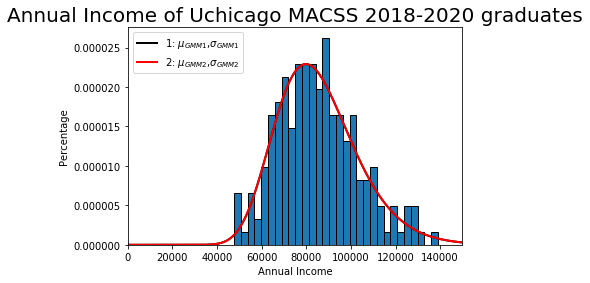

In [12]:
# Plot the histogram of the data
num_bins = 30
count, bins, ignored = plt.hist(inc['Income'], num_bins, density=True,
                                edgecolor='k')
plt.title('Annual Income of Uchicago MACSS 2018-2020 graduates', fontsize=20)
plt.xlabel(r'Annual Income')
plt.ylabel(r'Percentage')
plt.xlim([1, 150000])  # This gives the xmin and xmax to be plotted"

# Plot the estimated GMM PDF
plt.plot(dist_pts, trunc_lognorm_pdf(dist_pts, mu_GMM1, sig_GMM1, 0.0, 150000),
         linewidth=2, color='k', label='1: $\mu_{GMM1}$,$\sigma_{GMM1}$')

plt.plot(dist_pts, trunc_lognorm_pdf(dist_pts, mu_GMM2, sig_GMM2, 0.0, 150000),
         linewidth=2, color='r', label='2: $\mu_{GMM2}$,$\sigma_{GMM2}$')
plt.legend(loc='upper left')
plt.show()

### (d)

In [13]:
def data_moments3(xvals):
    bpct_1_dat = xvals[xvals < 75000].shape[0] / xvals.shape[0]
    bpct_2_dat = (xvals[(xvals >= 75000) & (xvals < 100000)].shape[0] /
                  xvals.shape[0])
    bpct_3_dat = xvals[xvals >= 100000].shape[0] / xvals.shape[0]

    return bpct_1_dat, bpct_2_dat, bpct_3_dat


def model_moments3(mu, sigma, cut_lb, cut_ub):
    xfx = lambda x: trunc_lognorm_pdf(x, mu, sigma, cut_lb, cut_ub)
    (bpct_1_mod, bp_1_err) = intgr.quad(xfx, 0.0, 75000)
    (bpct_2_mod, bp_2_err) = intgr.quad(xfx, 75000, 100000)
    (bpct_3_mod, bp_3_err) = intgr.quad(xfx, 100000, 150000)
    
    return bpct_1_mod, bpct_2_mod, bpct_3_mod


def err_vec3(xvals, mu, sigma, cut_lb, cut_ub, simple):
    bpct_1_dat, bpct_2_dat, bpct_3_dat = \
        data_moments3(xvals)
    moms_data = np.array([[bpct_1_dat], [bpct_2_dat], [bpct_3_dat]])
    bpct_1_mod, bpct_2_mod, bpct_3_mod = \
        model_moments3(mu, sigma, cut_lb, cut_ub)
    moms_model = np.array([[bpct_1_mod], [bpct_2_mod], [bpct_3_mod]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec


def criterion3(params, *args):
    mu, sigma = params
    xvals, cut_lb, cut_ub, W = args
    err = err_vec3(xvals, mu, sigma, cut_lb, cut_ub, simple=False)
    crit_val = err.T @ W @ err 
    return crit_val

In [14]:
W_hat_3 = np.eye(3)
gmm_args = (inc['Income'], 0.0, 150000, W_hat_3)
results_3 = opt.minimize(criterion3, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((None, None), (1e-10, None)))
mu_GMM_3, sig_GMM_3 = results_3.x
print('mu_GMM_3 =', mu_GMM_3, ' sig_GMM_3 =', sig_GMM_3)
err3 = err_vec3(inc['Income'], mu_GMM_3, sig_GMM_3, 0.0, 150000.0, False).reshape(3,)
print('Error vector:', err3)
print('The value of GMM criterion function:',results_3.fun[0,0])

mu_GMM_3 = 11.336705162764707  sig_GMM_3 = 0.21151353494384176
Error vector: [ 1.61522379e-07 -7.19526623e-08 -6.24019113e-08]
The value of GMM criterion function: 3.5160663053913126e-14


In [15]:
bpct_1_dat, bpct_2_dat, bpct_3_dat = data_moments3(inc['Income'])
bpct_1_mod, bpct_2_mod, bpct_3_mod = model_moments3(mu_GMM_3, sig_GMM_3, 0.0, 150000.0)
data_mm = [bpct_1_dat, bpct_2_dat, bpct_3_dat]
model_mm = [bpct_1_mod, bpct_2_mod, bpct_3_mod]
ind = ['< $75,000','\$75,000 - \$100,000','>= $100,000']
data = {'Data Moments':data_mm, 'Model Moments': model_mm}
pd.DataFrame(data, index = ind)

,Data Moments,Model Moments
"< $75,000",0.3,0.3
"\$75,000 - \$100,000",0.5,0.5
">= $100,000",0.2,0.2


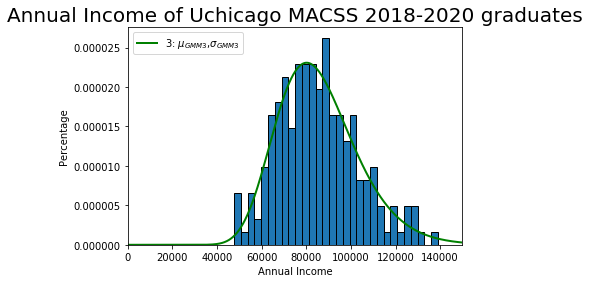

In [16]:
# Plot the histogram of the data
num_bins = 30
count, bins, ignored = plt.hist(inc['Income'], num_bins, density=True,
                                edgecolor='k')
plt.title('Annual Income of Uchicago MACSS 2018-2020 graduates', fontsize=20)
plt.xlabel(r'Annual Income')
plt.ylabel(r'Percentage')
plt.xlim([1, 150000])  # This gives the xmin and xmax to be plotted"

# Plot the estimated GMM PDF
plt.plot(dist_pts, trunc_lognorm_pdf(dist_pts, mu_GMM_3, sig_GMM_3, 0.0, 150000),
         linewidth=2, color='g', label='3: $\mu_{GMM3}$,$\sigma_{GMM3}$')

plt.legend(loc='upper left')
plt.show()

### (e)

In [17]:
def get_Err_mat3(pts, mu, sigma, cut_lb, cut_ub, simple=False):
    
    R = 3
    N = len(pts)
    Err_mat = np.zeros((R, N))
    pct_1_mod, pct_2_mod, pct_3_mod = \
        model_moments3(mu, sigma, cut_lb, cut_ub)
    if simple:
        pts_in_grp1 = pts < 75000
        Err_mat[0, :] = pts_in_grp1 - pct_1_mod
        pts_in_grp2 = (pts >= 75000) & (pts < 100000)
        Err_mat[1, :] = pts_in_grp2 - pct_2_mod
        pts_in_grp3 = pts >= 100000
        Err_mat[2, :] = pts_in_grp3 - pct_3_mod

    else:
        pts_in_grp1 = pts < 75000
        Err_mat[0, :] = (pts_in_grp1 - pct_1_mod) / pct_1_mod
        pts_in_grp2 = (pts >= 75000) & (pts < 100000)
        Err_mat[1, :] = (pts_in_grp2 - pct_2_mod) / pct_2_mod
        pts_in_grp3 = pts >= 100000
        Err_mat[2, :] = (pts_in_grp3 - pct_3_mod) / pct_3_mod
    
    return Err_mat

In [18]:
Err_mat3 = get_Err_mat3(inc['Income'], mu_GMM_3, sig_GMM_3, 0.0, 150000.0, False)
VCV2_3 = (1 / inc['Income'].shape[0]) * (Err_mat3 @ Err_mat3.T)
print('VCV2_3:\n', VCV2_3)
W_hat2_3 = lin.pinv(VCV2_3)
print('W_hat2_3:\n', W_hat2_3)

VCV2_3:
 [[ 2.33333258 -0.99999991 -0.9999999 ]
 [-0.99999991  1.00000014 -1.00000013]
 [-0.9999999  -1.00000013  4.0000005 ]]
W_hat2_3:
 [[ 0.25761775 -0.14958453 -0.01246539]
 [-0.14958453  0.11911361 -0.07340718]
 [-0.01246539 -0.07340718  0.20221604]]


In [19]:
gmm_args = (inc['Income'], 0.0, 150000.0, W_hat2_3)
results2_3 = opt.minimize(criterion3, params_init, args=(gmm_args),
                          method='L-BFGS-B', bounds=((None, None), (1e-10, None)))
mu_GMM2_3, sig_GMM2_3 = results2_3.x
print('mu_GMM2_3 =', mu_GMM2_3, ' sig_GMM2_3 =', sig_GMM2_3)
err2_3 = err_vec3(inc['Income'], mu_GMM2_3, sig_GMM2_3, 0.0, 150000.0, False).reshape(3,)
print('Error vector:', err2_3)
print('The value of GMM criterion function:',results2_3.fun[0,0])


mu_GMM2_3 = 11.336705114244221  sig_GMM2_3 = 0.21151358770054526
Error vector: [ 5.84568507e-07 -3.06908001e-07 -1.09582757e-07]
The value of GMM criterion function: 1.5201407065364736e-13


In [20]:
bpct_1_mod, bpct_2_mod, bpct_3_mod = model_moments3(mu_GMM2_3, sig_GMM2_3, 0.0, 150000.0)
model_mm = [bpct_1_mod, bpct_2_mod, bpct_3_mod]
ind = ['< $75,000','\$75,000 - \$100,000','>= $100,000']
data = {'Data Moments':data_mm, 'Model Moments': model_mm}
pd.DataFrame(data, index = ind)

,Data Moments,Model Moments
"< $75,000",0.3,0.3
"\$75,000 - \$100,000",0.5,0.5
">= $100,000",0.2,0.2


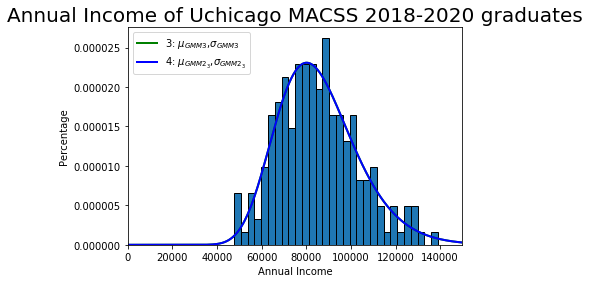

In [21]:
# Plot the histogram of the data
num_bins = 30
count, bins, ignored = plt.hist(inc['Income'], num_bins, density=True,
                                edgecolor='k')
plt.title('Annual Income of Uchicago MACSS 2018-2020 graduates', fontsize=20)
plt.xlabel(r'Annual Income')
plt.ylabel(r'Percentage')
plt.xlim([1, 150000])  # This gives the xmin and xmax to be plotted"

# Plot the estimated GMM PDF
plt.plot(dist_pts, trunc_lognorm_pdf(dist_pts, mu_GMM_3, sig_GMM_3, 0.0, 150000),
         linewidth=2, color='g', label='3: $\mu_{GMM3}$,$\sigma_{GMM3}$')

plt.plot(dist_pts, trunc_lognorm_pdf(dist_pts, mu_GMM2_3, sig_GMM2_3, 0.0, 150000),
         linewidth=2, color='b', label='4: $\mu_{GMM2_3}$,$\sigma_{GMM2_3}$')
plt.legend(loc='upper left')
plt.show()

### (f)

In [22]:
mu = [mu_GMM1, mu_GMM2, mu_GMM_3, mu_GMM2_3]
sigma = [sig_GMM1, sig_GMM2, sig_GMM_3, sig_GMM2_3]
gmm = [results.fun[0,0], results_2.fun[0,0], results_3.fun[0,0], results2_3.fun[0,0]]
data_2 = {'$\mu$':mu, '$\sigma$':sigma, 'GMM Value':gmm}
pd.DataFrame(data_2)


,$\mu$,$\sigma$,GMM Value
0,11.333533,0.213862,6.357621e-16
1,11.333533,0.213862,4.279415e-16
2,11.336705,0.211514,3.516066e-14
3,11.336705,0.211514,1.520141e-13


The second model (i.e. the model with the two moments weighted matrix) fits the data best, because it has the lowest value of GMM criterion function.

## Question 2

### (a)

In [23]:
def err(sick, b0, b1, b2, b3):
    y_hat = b0 + b1 * sick['age'] + b2 * sick['children'] + b3 * sick['avgtemp_winter']
    e = y_hat - sick['sick']
    e = np.array(e)
    return e

def crit_err(params, *args):
    b0, b1, b2, b3 = params
    sick, W = args
    e = err(sick, b0, b1, b2, b3)
    crit_val = e.T @ W @ e
    
    return crit_val

In [24]:
sick = pd.read_csv('data/sick.txt')
params_init = np.array([0.0, 0.0, 0.0, 0.0])
W = np.eye(sick.shape[0])
gmm_args = (sick, W)
results_sick = opt.minimize(crit_err, params_init, args=(gmm_args), tol=1e-14, method='L-BFGS-B')
b0 = results_sick.x[0]
b1 = results_sick.x[1]
b2 = results_sick.x[2]
b3 = results_sick.x[3]

In [25]:
print('Beta 0 estimation =', b0)
print('Beta 1 estimation =', b1)
print('Beta 2 estimation =', b2)
print('Beta 3 estimation =', b3)
print('Value of GMM criterion function =', results_sick.fun)

Beta 0 estimation = 0.2516447084200011
Beta 1 estimation = 0.012933458362211967
Beta 2 estimation = 0.4005011088429919
Beta 3 estimation = -0.009991699339527243
Value of GMM criterion function = 0.0018212898068018697
